In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#%tensorflow_version 2.x 
import tensorflow as tf

from PIL import Image
import glob
import cv2
import os
import sys

import keras
from keras.regularizers import l1, l2, l1_l2
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Conv2D, Dropout
from keras.layers import ConvLSTM2D, MaxPooling2D, Flatten, BatchNormalization, Conv3D
from keras.optimizers import SGD, Adam
from keras.utils import plot_model


/home/mlsg/mlsg-venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mlsg/mlsg-venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mlsg/mlsg-venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mlsg/mlsg-venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
import numpy as np

import csv
import math
import statistics
from scipy.spatial import distance
from mlxtend.image import extract_face_landmarks

In [3]:
# extract landmarks

def get_eyes_aspect_ratio(image_to_process):
    landmarks = extract_face_landmarks(image_to_process)
    left_eye_aspect_ratio, right_eye_aspect_ratio = calc_eyes_aspect_ratio(landmarks)
    return left_eye_aspect_ratio, right_eye_aspect_ratio
    
def calc_eyes_aspect_ratio(landmarks):
    left_eye = []
    right_eye = []
    for i in range(36, 42):
        left_eye.append([landmarks[i][0], landmarks[i][1]])
    for i in range(42, 48):
        right_eye.append([landmarks[i][0], landmarks[i][1]])
    return calc_eye_aspect_ratio(left_eye), calc_eye_aspect_ratio(right_eye)

def calc_eye_aspect_ratio(coords):
    height1 = distance.euclidean(coords[1], coords[5])
    height2 = distance.euclidean(coords[2], coords[4])
    length = distance.euclidean(coords[0], coords[3])
    return (height1 + height2) / (2 * length)


In [4]:
# This function helps to extract data and labels and return it as a Numpy array from a given image file
def extract_data_and_label(image_path):
    # We use opencv to read the images as grayscale, this will give us the 2d vector of pixels
    # Note that it returns a numpy array and not a Python list, but Keras uses Numpy arrays anyway
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Because some of the images are corrupt, we got to do this
    if image is None or image.data is None or image.size == 0:
        return None, None, None
    
    left_eye_aspect_ratio, right_eye_aspect_ratio = get_eyes_aspect_ratio(image)
    
    '''
    # Scale the images to a fixed size, second argument is the target dimension, chose an arbitrary
    # value for now, (100, 100). Additional arguments can be provided to fine-tune the scaling.
    image = cv2.resize(image, (1,129600))
    image = image / 255
    '''

    # Next is to extract the labels for each image, in our case, it is just the last portion of the filename
    file_name = os.path.basename(image_path)
    label = int(os.path.splitext(file_name)[0].split('_')[2])
    # Convert to 0, 1, 2
    label = 0 if label == 0 else 1 if label == 5 else 2

    return left_eye_aspect_ratio, right_eye_aspect_ratio, label

In [4]:
# Plot the training result
def plot_train(hist):
    h = hist.history
    if 'accuracy' in h:
        meas='accuracy'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

In [5]:
# print image
def print_image(image_to_print):
    plt.figure()
    plt.imshow(image_to_print, cmap='gray') 
    plt.show()

# This part for normalised values

In [8]:
def get_row(row):
    result = []
    for val in row:
        result.append(float(val))
    
    return result

TRAINING_DATA_PATH='/home/mlsg/DiskA/others/ratios'
VALIDATION_DATA_PATH='/home/mlsg/DiskB/others/ratios'

x_train = []
y_train = []

for csv_dir in os.listdir(TRAINING_DATA_PATH):
    full_path = TRAINING_DATA_PATH + '/' + csv_dir
    endings = ['0', '10']
    
    for ending in endings:
        filename = full_path + '/' + ending + '.csv'
        if os.path.exists(filename):
            with open(filename, mode='r') as f:
                reader = csv.reader(f)
                for row in reader:
                    if (len(row) > 6):
                        x_train.append([float(row[5]), float(row[6]), float(row[7]), float(row[8])])
                        
                        if (int(ending) == 0):
                            y_train.append(int(0))
                        elif int(ending) == 5:
                            y_train.append(int(1))
                        elif int(ending) == 10:
                            y_train.append(int(1))
                            

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []

for csv_dir in os.listdir(VALIDATION_DATA_PATH):
    full_path = VALIDATION_DATA_PATH + '/' + csv_dir
    endings = ['0', '10']
    
    for ending in endings:
        filename = full_path + '/' + ending + '.csv'
        if os.path.exists(filename):
            with open(filename, mode='r') as f:
                reader = csv.reader(f)
                for row in reader:
                    if (len(row) > 6):
                        x_test.append([float(row[5]), float(row[6]), float(row[7]), float(row[8])])
                        
                        if (int(ending) == 0):
                            y_test.append(int(0))
                        elif int(ending) == 5:
                            y_test.append(int(1))
                        elif int(ending) == 10:
                            y_test.append(int(1))

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(85875, 4)
(85875,)
(59889, 4)
(59889,)


In [9]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(x_train[0])
print(y_train[0])
print(x_train[0][0])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

x_train = x_train.reshape(len(x_train), 1, 4)
x_test = x_test.reshape(len(x_test), 1, 4)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

85875
85875
59889
59889
[ 0.29753638 -0.03287357 -0.09855425 -0.23360286]
0
0.29753637672852506
(85875, 4)
(85875,)
(59889, 4)
(59889,)


# This part for the non-generator method

In [7]:
training_image_src = '../driver-drowsiness-detection/processing/training_aspect_ratios.csv'
validation_image_src = '../driver-drowsiness-detection/processing/validation_aspect_ratios.csv'

x_train = []
y_train = []
with open(training_image_src, mode='r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    row_count = 0
    for row in csv_reader:
        x_train.append([float(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5])])
        if (str(row[6]) == "2"):
            y_train.append(1)
        elif str(row[6]) == "0":
            y_train.append(0)
        
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []

with open(validation_image_src, mode='r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        x_test.append([float(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5])])
        if (str(row[6]) == "2"):
            y_test.append(1)
        elif str(row[6]) == "0":
            y_test.append(0)
        
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(len(x_train), 1, 6)
x_test = x_test.reshape(len(x_test), 1, 6)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(86642, 1, 6)
(86642, 2)
(23559, 1, 6)
(23559, 2)


Train model here

In [10]:
# Adjusts these parameters to our liking
lr = 0.001
training_epochs = 10
batch_size = 100 # How many images we want it to process at any given time

n_input_shape = (1, 4)  # data input (img shape: 360*360 flattened to be 129600)
n_input_size = 360 #720  #input layer number of neurons
n_hidden_1 = 100 #360  #1st layer number of neurons
n_hidden_2 = 100#360  #2nd layer number of neurons
n_classes = 2

regularizer = l2(0.001)
opt = Adam() #SGD(lr=learning_rate)
loss_fn = 'categorical_crossentropy'

# Sequential 
# Edit the model here
model = Sequential(name="MLP")
model.add(Dense(n_input_size, activation='relu', name="Input", 
                activity_regularizer=regularizer, kernel_regularizer=regularizer,
                input_shape=(n_input_shape)))
model.add(Dropout(rate=0.001))
model.add(Dense(n_hidden_1, activation='relu', name="Hidden_1", 
                activity_regularizer=regularizer, kernel_regularizer=regularizer))
model.add(Dropout(rate=0.001))
model.add(Dense(n_hidden_2, activation='relu', name="Hidden_2", 
                activity_regularizer=regularizer, kernel_regularizer=regularizer))
model.add(Dropout(rate=0.001))
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax', 
                activity_regularizer=regularizer, kernel_regularizer=regularizer,
                name="Output"))

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 1, 360)            1800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 360)            0         
_________________________________________________________________
Hidden_1 (Dense)             (None, 1, 100)            36100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
Hidden_2 (Dense)             (None, 1, 100)            10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0       

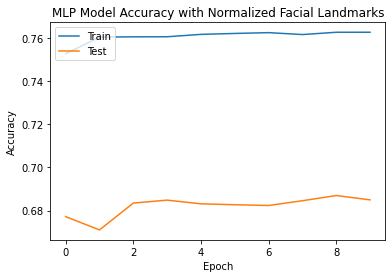

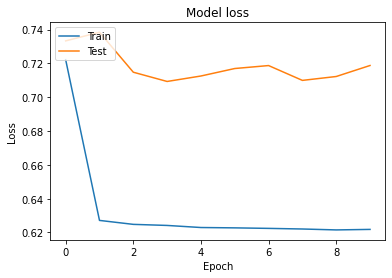

In [11]:
model.summary()

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("mlp.h5");

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP Model Accuracy with Normalized Facial Landmarks')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('mlp_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('mlp_loss.png')
plt.show()

In [39]:
def new_model():
    lr = 0.001
    training_epochs = 10
    batch_size = 100 # How many images we want it to process at any given time

    n_input_shape = (1, 4)  # data input (img shape: 360*360 flattened to be 129600)
    n_input_size = 360 #720  #input layer number of neurons
    n_hidden_1 = 100 #360  #1st layer number of neurons
    n_hidden_2 = 100#360  #2nd layer number of neurons
    n_classes = 2

    regularizer = l2(0.001)
    opt = Adam() #SGD(lr=learning_rate)
    loss_fn = 'categorical_crossentropy'

    # Sequential 
    # Edit the model here
    model = Sequential(name="MLP")
    model.add(Dense(n_input_size, activation='relu', name="Input", 
                    activity_regularizer=regularizer, kernel_regularizer=regularizer,
                    input_shape=(n_input_shape)))
    model.add(Dropout(rate=0.001))
    model.add(Dense(n_hidden_1, activation='relu', name="Hidden_1", 
                    activity_regularizer=regularizer, kernel_regularizer=regularizer))
    model.add(Dropout(rate=0.001))
    model.add(Dense(n_hidden_2, activation='relu', name="Hidden_2", 
                    activity_regularizer=regularizer, kernel_regularizer=regularizer))
    model.add(Dropout(rate=0.001))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax', 
                    activity_regularizer=regularizer, kernel_regularizer=regularizer,
                    name="Output"))
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

    return model
    

In [40]:
def train_and_evaluate(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y, epochs=30, batch_size=10)
    # evaluate the model
    scores = model.evaluate(test_x, test_y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return scores

In [41]:
from sklearn.model_selection import StratifiedKFold

labels = np.concatenate([y_train, y_test])
data = np.concatenate([x_train, x_test])
# labels = data_y.concat(data_x)
scores = []
n_folds = 5

new_labels = []
for c in labels:
    if c[0] == 0.0:
        new_labels.append(1)
    else:
        new_labels.append(0)
    
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train, test in skf.split(data, new_labels):
    eval_model = None # Clearing the NN.
    eval_model = new_model()
    score = train_and_evaluate(eval_model, data[np.array(train)], labels[np.array(train)], data[np.array(test)], labels[np.array(test)])
    scores.append(score[1])

Epoch 1/30
116611/116611 [==============================] - 26s 224us/step - loss: 0.5952 - accuracy: 0.7232
Epoch 2/30
116611/116611 [==============================] - 27s 228us/step - loss: 0.5802 - accuracy: 0.7287
Epoch 3/30
116611/116611 [==============================] - 26s 219us/step - loss: 0.5780 - accuracy: 0.7309
Epoch 4/30
116611/116611 [==============================] - 26s 219us/step - loss: 0.5764 - accuracy: 0.7322
Epoch 5/30
116611/116611 [==============================] - 26s 219us/step - loss: 0.5763 - accuracy: 0.7323
Epoch 6/30
116611/116611 [==============================] - 26s 219us/step - loss: 0.5755 - accuracy: 0.7329
Epoch 7/30
116611/116611 [==============================] - 26s 219us/step - loss: 0.5749 - accuracy: 0.7333
Epoch 8/30
116611/116611 [==============================] - 26s 224us/step - loss: 0.5746 - accuracy: 0.7337
Epoch 9/30
116611/116611 [==============================] - 26s 219us/step - loss: 0.5745 - accuracy: 0.7331
Epoch 10/30
116611/

116612/116612 [==============================] - 28s 239us/step - loss: 0.5700 - accuracy: 0.7387
Epoch 30/30
116612/116612 [==============================] - 28s 240us/step - loss: 0.5699 - accuracy: 0.7390
accuracy: 73.10%


In [12]:
from sklearn.metrics import roc_curve
from sklearn import metrics

pred = model.predict(x_test)
new_y_test = []
for c in y_test:
    if c[0] == 0.0:
        new_y_test.append(1)
    else:
        new_y_test.append(0)
fpr_mlp, tpr_mlp, thresholds = roc_curve(new_y_test, [c[1] for c in pred])
roc_auc = metrics.auc(fpr_mlp, tpr_mlp)


In [13]:
%store fpr_mlp
%store tpr_mlp

Stored 'fpr_mlp' (ndarray)
Stored 'tpr_mlp' (ndarray)


In [14]:
import statistics

print(statistics.mean(scores))
print(statistics.stdev(scores))

NameError: name 'scores' is not defined

# The below is for generator

In [ ]:
"""
Gonna have to do the procesing in batches because the images are too big to fit all on the ram at the same time.
To do so, we define a generator function that will help pull data in batches from the disks.

https://mc.ai/train-keras-model-with-large-dataset-batch-training/
"""
def batch_generator(files, batch_size):
    counter = 0
    while True:
        pixels = []
        labels = []

        # print('Generating batch...')
        while len(pixels) < batch_size:
            filename = files[counter]
            try:
                left_eye_aspect_ratio, right_eye_aspect_ratio, label = extract_data_and_label(filename)
            except:
                counter = (counter + 1) % len(files)
                continue
            #if data is None and label is None:
            if left_eye_aspect_ratio is None or right_eye_aspect_ratio is None or label is None:
                counter = (counter + 1) % len(files)
                continue

            counter = (counter + 1) % len(files)
            pixels.append([left_eye_aspect_ratio, right_eye_aspect_ratio])
            labels.append(label)

        pixels = np.array(pixels)
        labels = np.array(labels)

        pixels = pixels.reshape(batch_size, 1, 2)
        
        """
        We one-hot-encode our labels to create 3 cateogories, 0 being mapped awake, 5 being mapped to normal and 10 being
        mapped to sleepy

        !!! Perhaps there can be a better way of encoding the output data? Will this method result in a loss of ordinality?
        """
        labels = tf.keras.utils.to_categorical(labels, num_classes=3)
        # yield is a Python thing for generators
        yield pixels, labels

In [ ]:
for i in range(1) :
    pixel, labels = next(batch_generator(validation_files, 100))
    print(str(i))
    print("pixel: ", len(pixel))
    print("labels: ", len(labels))
    print(labels[0])

In [ ]:
# This part loads the training & validation files' location
# Location of frames
training_image_src = '../DiskA/others/faces-resized'
validation_image_src = '../DiskB/others/faces-resized'

training_files = []
for root, dirs, files in os.walk(training_image_src):
    for file in files:
        file_path = os.path.join(root, file)
        training_files.append(file_path)

validation_files = []
for root, dirs, files in os.walk(validation_image_src):
    for file in files:
        file_path = os.path.join(root, file)
        validation_files.append(file_path)
        
# Checking the size to confirm that the files are loaded
print("size of training files =", len(training_files))
print("size of validation files =", len(validation_files))

# image = extract_data_and_label(training_files[2])
# print("shape of image:", image[0].shape)

#print_image(mpimg.imread(training_files[1]))
image1 = cv2.imread(training_files[10], cv2.IMREAD_GRAYSCALE)

left_eye_aspect_ratio, right_eye_aspect_ratio = get_eyes_aspect_ratio(image1)
test_pixel = []
test_pixel.append([left_eye_aspect_ratio, right_eye_aspect_ratio])

image2 = cv2.imread(training_files[50], cv2.IMREAD_GRAYSCALE)

left_eye_aspect_ratio, right_eye_aspect_ratio = get_eyes_aspect_ratio(image2)
test_pixel.append([left_eye_aspect_ratio, right_eye_aspect_ratio])
test_pixel

In [ ]:
import random

training_sample_size = len(training_files)
validation_sample_size = len(validation_files)
# Checking the size to confirm that the files are loaded
print("size of training files =", str(training_sample_size))
print("size of validation files =", str(validation_sample_size))

In [ ]:
training_files = random.sample(training_files, training_sample_size)
validation_files = random.sample(validation_files, validation_sample_size)

# Adjusts these parameters to our liking
learning_rate = 0.001
training_epochs = 5
batch_size = 50 # How many images we want it to process at any given time

training_generator = batch_generator(training_files, batch_size)
validation_generator = batch_generator(validation_files, batch_size)

n_input_shape = (1, 2)  # data input (img shape: 360*360 flattened to be 129600)
n_input_size = 720 # input layer number of neurons
n_hidden_1 = 360 # 1st layer number of neurons
n_hidden_2 = 360 # 2nd layer number of neurons
n_classes = 3 # MNIST classes for prediction(digits 0-10)

regularizer = l2(0.001)

# Sequential 
# Edit the model here
model = Sequential(name="MLP")
model.add(Dense(n_input_size, activation='relu', name="Input", 
                kernel_regularizer=regularizer, input_shape=(n_input_shape)))
model.add(Dense(n_hidden_1, activation='relu', name="Hidden_1",
                kernel_regularizer=regularizer))
model.add(Dense(n_hidden_2, activation='relu', name="Hidden_2",
                kernel_regularizer=regularizer))
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=regularizer, 
                name="Output"))

In [ ]:
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(training_generator, 
                              validation_data=validation_generator, 
                              epochs=training_epochs, 
                              steps_per_epoch=np.ceil(len(training_files)/batch_size), 
                              validation_steps=np.ceil(len(validation_files)/batch_size), 
                              verbose=1, 
                              shuffle=True)

model.save("mlp.h5");

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('mlp_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('mlp_loss.png')
plt.show()

In [ ]:
# DO NOT RUN ANYTHING ELSE FROM HERE ON
'''
# training_image_name_pixel_label = {}
# validation_image_name_pixel_label = {}

# loads the images into arrays
x_train = [] # actual pixel values of training images
y_train = [] # label / classification
x_test = []
y_test = []
'''

for filename in glob.glob(training_image_src + '*.jpg'):
    im=cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    #print(im.shape)
    #print(im)
    #plt.imshow(im, cmap='gray')
    label = filename[len(filename) - 6: len(filename) - 4]
    if label == "_5":
      label = str(0)
    elif label == "_0":
      label = str(1)
    elif label == "10":
      label = str(2)
    im= im/255
    im.resize(129600) #uncomment this if dont have to flatten it
    x_train.append(im)
    y_train.append(int(label))

print(x_train.shape)

'''
for filename in glob.glob(validation_image_src + '*.jpg'):
    im=cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    #print(im.shape)
    #print(im)
    #plt.imshow(im, cmap='gray')
    label = filename[len(filename) - 6: len(filename) - 4]
    if label == "_0":
      label = str(0)
    elif label == "_5":
      label = str(1)
    elif label == "10":
      label = str(2)
    im= im/255
    im.resize(129600) #uncomment this if dont have to flatten it
    x_test.append(im)
    y_test.append(int(label))
    #image_name_pixel_label[filename] = (im, label)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

n_classes = 3
'''

In [ ]:
#list(image_name_pixel_label.values())[0][0].shape
print("len(x_train):", len(x_train))
print("x_train.shape:", x_train.shape)
print("len(y_train):", len(y_train))
print("y_train.shape:", y_train.shape)
print("len(x_test):", len(x_test))
print("len(y_test):", len(y_test))

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

learning_rate = 0.001
training_epochs = 50
batch_size = 50 # How many images we want it to process at any given time

n_input_shape = 129600  # data input (img shape: 360*360 flattened to be 129600)
n_input_size = 720 # input layer number of neurons
n_hidden_1 = 360 # 1st layer number of neurons
n_hidden_2 = 360 # 2nd layer number of neurons
n_classes = 3 # MNIST classes for prediction(digits 0-10)

regularizer = l2(0.001)

# Sequential 
model = Sequential(name="MLP")
model.add(Dense(n_input_size, activation='relu', name="Input", 
                kernel_regularizer=regularizer, input_shape=(n_input_shape,)))
model.add(Dense(n_hidden_1, activation='relu', name="Hidden_1",
                kernel_regularizer=regularizer))
model.add(Dense(n_hidden_2, activation='relu', name="Hidden_2",
                kernel_regularizer=regularizer))
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=regularizer, 
                name="Output"))

'''
# Functional
Inp = Input(shape = (n_input_shape,))
x = Dense(n_hidden_1, activation='relu', name = "Dense_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Dense_2")(x)
output = Dense(n_classes, activation='softmax', name = "OutputLayer")(x)
model = Model(Inp, output, name = "our_dense_model")
'''

model.summary()

opt = SGD(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot graph
plot_train(history)